In [1]:
#Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import svm

# Start writing code here...

### Import The Data

In [2]:
# Import the dataframe
titles = pd.read_csv("Fault_Column_Names.txt", header = None)
df = pd.read_csv('Fault_Variables_dataset.csv', sep="\t", names=titles[0])

# List the fault labels
faults_list=df.columns.values[-7:]

# Get the corresponding label of each instance. Check the maximum value in the last 7 columns.
# Take the column name of the maximum value (Which would be 1 among all the zeroes)
labels=(df.iloc[:,-7:]==1).idxmax(axis=1)

# Drop the one hot encoded columns
df=df.drop(faults_list,axis=1)

# Add the list of the labels as a column
df['Labels']=labels
df.head()


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Labels
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,Pastry
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,Pastry
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,Pastry
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,Pastry
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,Pastry


### Preprocessing

In [3]:
# Split the features and variables in different data frames.
df_y = df.iloc[:,-1:]
df_x = df.iloc[:,:-1]

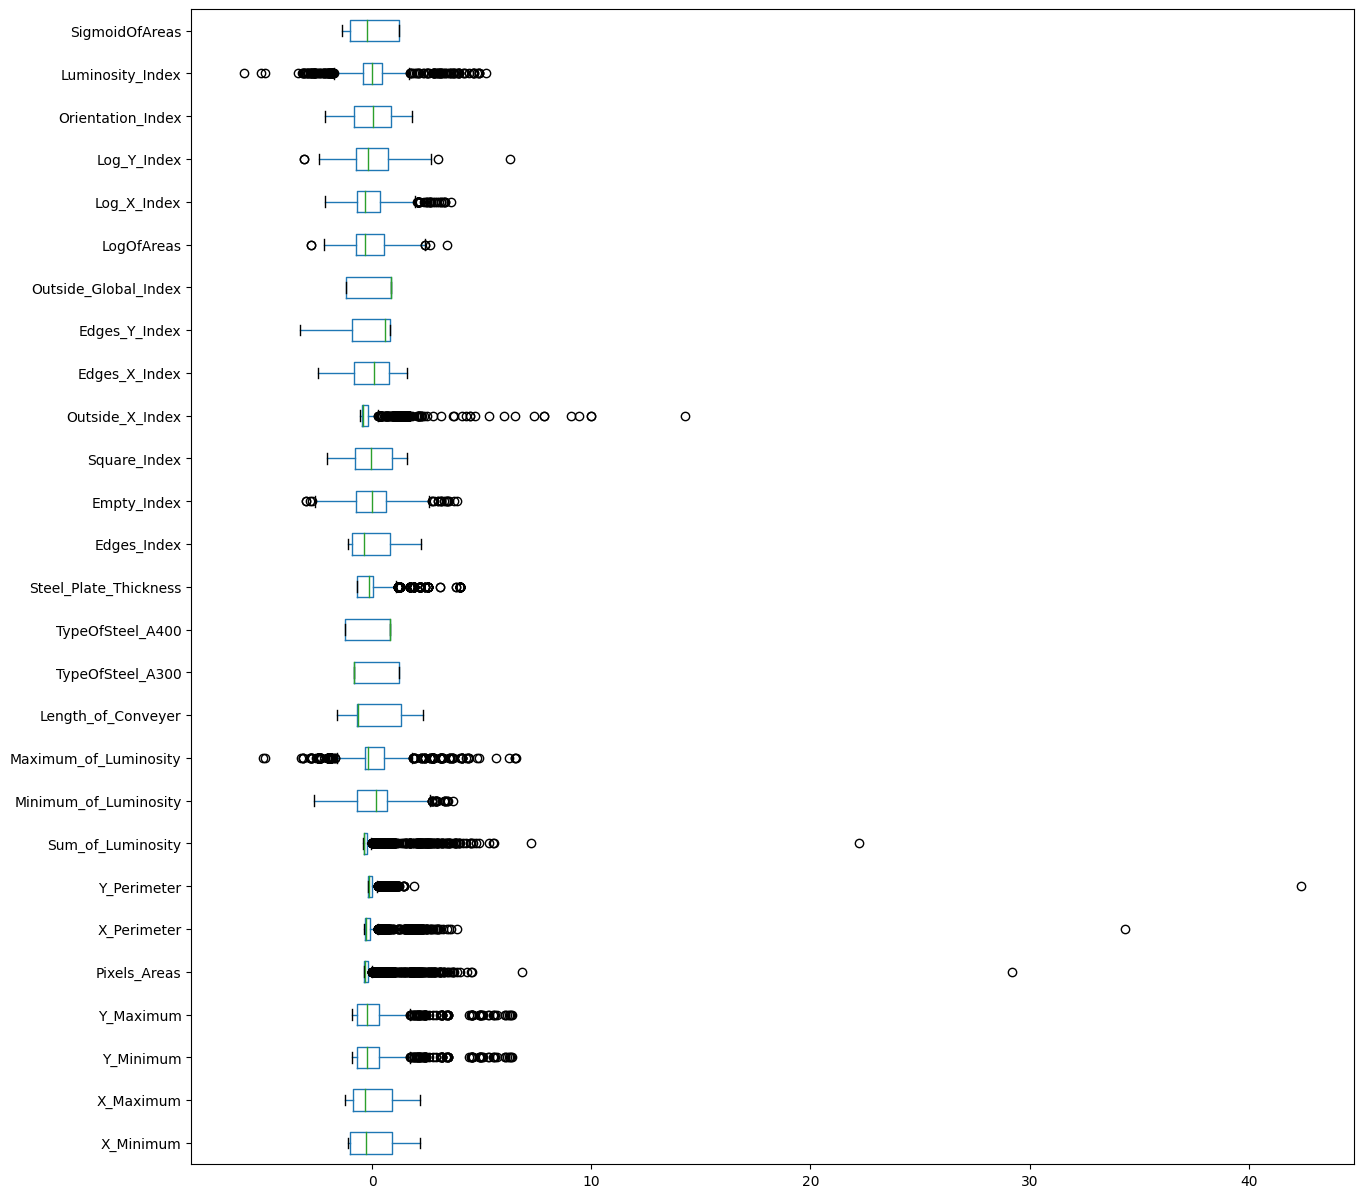

In [4]:
# Scale the features
df_std = pd.DataFrame(sc.fit_transform(df_x), columns = df_x.columns)
df_std.plot(kind='box', layout=(9,3), sharex=False, sharey=False, figsize=(15,15), vert=False )
plt.show()

The scaled version seems better. There are still outliers but because we cannot make sure that outliers are not relevant for the study, and SME opinion would be needed to delete them.

In [5]:
# Split the scaled dataset into train and test sets. We will use this split all the models
X_train,X_test,y_train,y_test = train_test_split(df_std,df_y,test_size = 0.3,\
random_state = 4)


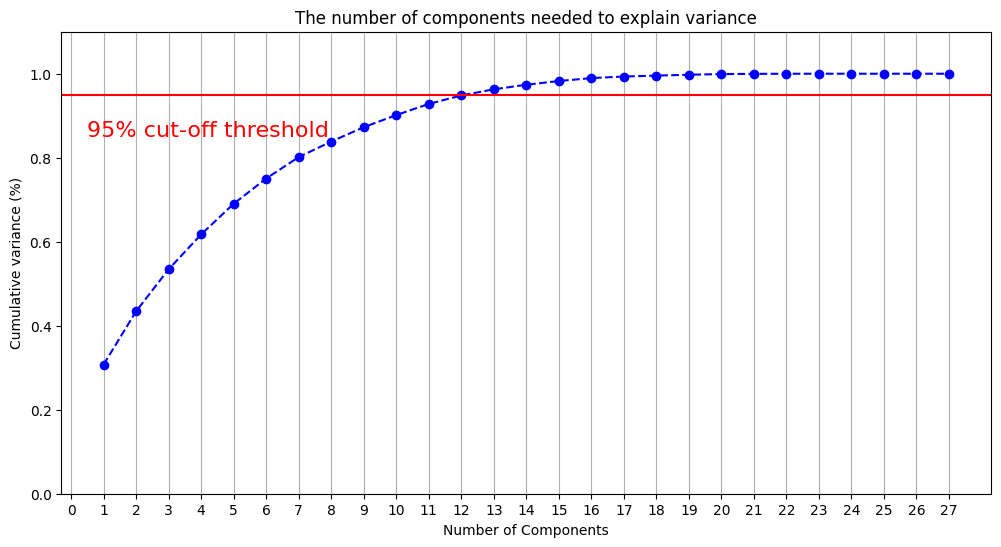

In [6]:
# We also want to apply before creating the models.
# So that we can compare the results after applying the models to before and after pca versions
# Fit the PCA to our data and plot the explained variance to select number of components
#
pca = PCA().fit(df_std)

plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1, 28, step=1)
y = np.cumsum(pca.explained_variance_ratio_) #y axis is cumulative sum of explained variance


plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 28, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

## Inspired by https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/


In [7]:
# Print the eigenvaluess and explained variances to see the exact values.
# Explained variance is around 95% even when reduce the dimensionality to half (from 27 to 12)
# This is probably because many of the variables were correlated.

cov_x = np.cov(df_std, rowvar=False)
eigenval, eigenvec = np.linalg.eig(cov_x)
xi = np.arange(1, 28, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
z = eigenval

for i in range(27):
    print([xi[i], y[i], z[i]])

[1, 0.30752951868179906, 8.307577054410864]
[2, 0.43419953557268076, 3.421853389278584]
[3, 0.5343431490063751, 2.7052713140307287]
[4, 0.6172289353764548, 2.2390697970601887]
[5, 0.6902472881362892, 1.9725117593219765]
[6, 0.7503833795009474, 1.624511412447239]
[7, 0.8014195972539615, 1.3786881772073292]
[8, 0.8384459893338432, 1.0002279019228615]
[9, 0.8725841795643217, 0.9222062553653048]
[10, 0.9015068943197108, 0.7813158310235485]
[11, 0.9280064501561468, 0.7158568158351045]
[12, 0.9482740608145032, 0.5475075627693207]
[13, 0.9628351537294902, 0.39335216309058124]
[14, 0.9737551200218001, 0.29499106880468084]
[15, 0.9826170468449353, 0.23939536031961112]
[16, 0.9896084088089635, 0.1888640754890854]
[17, 0.9933152927643549, 0.10013745744855511]
[18, 0.9955120145466363, 0.05934206105361718]
[19, 0.9975689016155711, 0.055564577640035445]
[20, 0.9992283884296328, 0.04482923993017147]
[21, 0.9996713283248971, 0.011965541799544661]
[22, 0.9999308072247832, 0.007009541601200562]
[23, 0.9

In [8]:
# Apply PCA to the scaled dataframe
df_pca = pd.DataFrame(PCA(n_components = 12).fit_transform(df_std))

# Split the PCA dataset into train and test sets.
pca_X_train,pca_X_test,pca_y_train,pca_y_test = train_test_split(df_pca,df_y, \
test_size = 0.3,random_state = 4)

### Models

In [9]:
# Building a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,KFold

logreg = LogisticRegression(max_iter=300)
kfold = KFold(n_splits=10,shuffle=True,random_state=4).get_n_splits(df_std.values)

cv_results = cross_val_score(logreg,X_train,y_train.values.ravel(),cv = kfold)

print('Mean of accuracies without PCA:',np.mean(cv_results), 
'Mean of SD without PCA:',np.std(cv_results,ddof =1),sep='\n')

logreg = LogisticRegression(max_iter=300)
kfold = KFold(n_splits=10,shuffle=True,random_state=4).get_n_splits(df_pca.values)

cv_results = cross_val_score(logreg,pca_X_train,pca_y_train,cv = kfold)

print('Mean of accuracies after PCA:',np.mean(cv_results), 
'Mean of SD after PCA:',np.std(cv_results,ddof =1),sep='\n')

Mean of accuracies without PCA:
0.7046895424836602
Mean of SD without PCA:
0.02240178193684374
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/valida

The PCA did not make a big difference in terms of accuracy in LogisticRegression. Overall LogisticRegression has an accuracy around 70%

In [10]:
# Building Suppoct Vector Classifier with the parameters Peter found with gridsearch :)
SVM_model = svm.SVC(C=5, coef0=1, degree=4, probability=True)
SVM_model.fit(X_train,y_train.values.ravel())
svm_pred = SVM_model.predict(X_test)
print(classification_report(y_test,svm_pred))


              precision    recall  f1-score   support

       Bumps       0.65      0.73      0.68       121
   Dirtiness       0.93      0.76      0.84        17
    K_Scatch       0.96      0.93      0.95       131
Other_Faults       0.70      0.72      0.71       194
      Pastry       0.68      0.50      0.57        54
      Stains       0.85      0.85      0.85        13
   Z_Scratch       0.87      0.89      0.88        53

    accuracy                           0.77       583
   macro avg       0.80      0.77      0.78       583
weighted avg       0.77      0.77      0.77       583



In [11]:
# Applying SVC to the PCA version.
SVM_model = svm.SVC(C=5, coef0=1, degree=4, probability=True)
SVM_model.fit(pca_X_train,pca_y_train)
pca_svm_pred = SVM_model.predict(pca_X_test)
print(classification_report(pca_y_test,pca_svm_pred))


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
              precision    recall  f1-score   support

       Bumps       0.64      0.71      0.67       121
   Dirtiness       0.87      0.76      0.81        17
    K_Scatch       0.95      0.94      0.95       131
Other_Faults       0.69      0.71      0.70       194
      Pastry       0.72      0.48      0.58        54
      Stains       0.85      0.85      0.85        13
   Z_Scratch       0.84      0.91      0.87        53

    accuracy                           0.76       583
   macro avg       0.79      0.76      0.78       583
weighted avg       0.76      0.76      0.76       583



The results are better than LogisticRegression. PCA did not lead to sacrificing much accuracy.

In [12]:
# Apply random forest classifier
forest = RandomForestClassifier(n_estimators=500, random_state=4,\
 class_weight="balanced")

# Training the model
forest.fit(X_train, y_train.values.ravel())

# Make prediction with the test sample
y_pred = forest.predict(X_test)

# Generate the classification report by comparing the predictions and the actual values
print(classification_report(y_test, y_pred))

# Print the accuracy to see the decimal places
print("Exact accuracy is: ", forest.score(X_test, y_test.values.ravel()))

              precision    recall  f1-score   support

       Bumps       0.72      0.65      0.68       121
   Dirtiness       0.93      0.76      0.84        17
    K_Scatch       0.99      0.95      0.97       131
Other_Faults       0.70      0.82      0.75       194
      Pastry       0.80      0.59      0.68        54
      Stains       0.85      0.85      0.85        13
   Z_Scratch       0.92      0.87      0.89        53

    accuracy                           0.80       583
   macro avg       0.84      0.79      0.81       583
weighted avg       0.81      0.80      0.80       583

Exact accuracy is:  0.7993138936535163


Peter ran the grid search on his computer because the ram of this virtual machine was not enough. The random forest with the resulting parameters is in the next cell.

In [13]:
# Apply random forest classifier
forest = RandomForestClassifier(n_estimators=200, criterion = "entropy",\
 max_features = None, min_samples_split = 5, random_state=4, class_weight="balanced")

# Training the model
forest.fit(X_train, y_train.values.ravel())
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))
print(forest.score(X_test, y_test.values.ravel()))

              precision    recall  f1-score   support

       Bumps       0.70      0.69      0.69       121
   Dirtiness       0.93      0.76      0.84        17
    K_Scatch       0.98      0.96      0.97       131
Other_Faults       0.71      0.80      0.75       194
      Pastry       0.73      0.56      0.63        54
      Stains       0.85      0.85      0.85        13
   Z_Scratch       1.00      0.92      0.96        53

    accuracy                           0.80       583
   macro avg       0.84      0.79      0.81       583
weighted avg       0.81      0.80      0.80       583

0.8027444253859348


Gridsearch didn't make wonders but we take it because of this slight increase in the decimal parts of the accuracy score.

Now we will try to apply PCA and compare the results.

In [14]:
# Training the model
forest.fit(pca_X_train, pca_y_train.values.ravel())
pca_y_pred = forest.predict(pca_X_test)
print(classification_report(pca_y_test, pca_y_pred))
print(forest.score(pca_X_test, pca_y_test.values.ravel()))

              precision    recall  f1-score   support

       Bumps       0.64      0.64      0.64       121
   Dirtiness       0.88      0.88      0.88        17
    K_Scatch       0.94      0.95      0.95       131
Other_Faults       0.68      0.70      0.69       194
      Pastry       0.72      0.63      0.67        54
      Stains       0.79      0.85      0.81        13
   Z_Scratch       0.85      0.83      0.84        53

    accuracy                           0.76       583
   macro avg       0.79      0.78      0.78       583
weighted avg       0.76      0.76      0.76       583

0.758147512864494


PCA reduced the accuracy of the model to 76% from 80%. Now RandomForestClassifier is not outperforming SVC. So we sacrificed some accuracy to lower required computing resources and to increase scalability. Making a decision about this trade off should not be on us, this is something to discuss with the SME. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7d583fb5-f0c9-4f5f-bb6c-438ad8bfb31a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>